In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

ModuleNotFoundError: No module named 'torch'

In [4]:
data_flag = 'retinamnist'
download = True

NUM_EPOCHS = 30
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Frederik Hausteng\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\Frederik Hausteng\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\Frederik Hausteng\.medmnist\retinamnist.npz


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset RetinaMNIST (retinamnist)
    Number of datapoints: 1080
    Root location: C:\Users\Frederik Hausteng\.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
Dataset RetinaMNIST (retinamnist)
    Number of datapoints: 400
    Root location: C:\Users\Frederik Hausteng\.medmnist
    Split: test
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0'

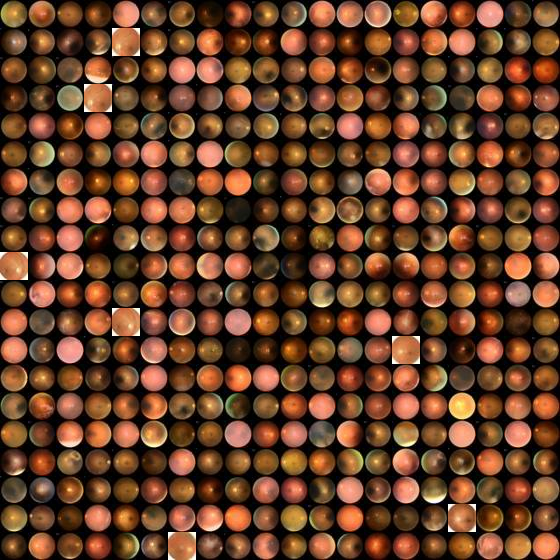

In [7]:
train_dataset.montage(length=20)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)

def ResNet50(in_channels, num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], in_channels=in_channels, num_classes=num_classes)

model = ResNet18(in_channels=n_channels, num_classes=n_classes)
    

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA FUNKER")
    model = model.cuda()  # Move the model to GPU

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        return F.relu(self.bn(self.upsample(self.conv(x))))

class ResNetSegmentation(nn.Module):
    def __init__(self, base_model, n_classes):
        super(ResNetSegmentation, self).__init__()
        self.base_model = base_model
        
        # Assuming base_model's last output has 512 channels
        self.decoder = nn.Sequential(
            UpSampleBlock(512, 256),
            UpSampleBlock(256, 128),
            UpSampleBlock(128, 64),
            UpSampleBlock(64, 32)
        )
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x = self.base_model(x)
        # Decoder
        x = self.decoder(x)
        # Final 1x1 convolution to get the required number of classes
        x = self.final_conv(x)
        return x

# Instantiate the segmentation model
model = ResNet50(in_channels=n_channels, num_classes=n_classes)  # or just ResNet(...)
segmentation_model = ResNetSegmentation(model, n_classes=n_classes)

# Replace the criterion with a segmentation-appropriate loss, like nn.CrossEntropyLoss or nn.BCEWithLogitsLoss for multi-class/multi-label segmentation.
criterion = nn.CrossEntropyLoss()

# The optimizer would remain the same
optimizer = optim.SGD(segmentation_model.parameters(), lr=lr, momentum=0.9)


In [11]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 34/34 [01:28<00:00,  2.60s/it]


In [12]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.997  acc:0.916
test  auc: 0.646  acc:0.458


train  auc: 1.000  acc:1.000
test  auc: 0.708  acc:0.472 (64 batch size epochs 10)

train  auc: 1.000  acc:1.000
test  auc: 0.711  acc:0.472 (32 batch size epochs 10)

==> Evaluating ...
train  auc: 0.997  acc:0.916
test  auc: 0.646  acc:0.458 (32 batch epochs 30)

In [ ]:
def binary_iou(preds, labels):
    print("Preds shape:", preds.shape)
    print("Labels shape:", labels.shape)
    # preds and labels should be boolean tensors where True indicates presence of the class
    intersection = (preds & labels).float().sum((1, 2))  # Intersection points
    union = (preds | labels).float().sum((1, 2))         # Union points

    iou = (intersection + 1e-6) / (union + 1e-6)  # We add small epsilon to avoid division by zero
    return iou.mean()  # Return the mean IoU over the batch

def multi_class_iou(preds, labels, num_classes):
    iou_list = []
    preds = torch.argmax(preds, dim=1)  # Convert softmax outputs to class predictions
    for cls in range(num_classes):  # Iterate over each class
        preds_cls = (preds == cls)  # Predictions for class cls
        labels_cls = (labels == cls)  # Labels for class cls

        intersection = (preds_cls & labels_cls).float().sum()
        union = (preds_cls | labels_cls).float().sum()

        iou = (intersection + 1e-6) / (union + 1e-6)  # IoU for class cls
        iou_list.append(iou.item())
    return np.mean(iou_list)  # Return the mean IoU over all classes


In [ ]:
def test(split):
    model.eval()
    iou_scores = []

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)  # if binary segmentation
            # outputs = torch.argmax(outputs, dim=1)  # if multi-class segmentation

            preds = outputs > 0.5  # threshold for binary segmentation
            # preds = outputs  # if already done argmax for multi-class

            # Compute IoU here
            for pred, target in zip(preds, targets):
                iou = binary_iou(pred, target)  # Assuming binary segmentation
                # iou = multi_class_iou(pred, target, num_classes)  # For multi-class segmentation
                iou_scores.append(iou.item())

    # Compute and print the mean IoU
    mean_iou = np.mean(iou_scores)
    print(f'{split} Mean IoU: {mean_iou:.3f}')

print('==> Evaluating ...')
test('train')
test('test')


==> Evaluating ...
Preds shape: torch.Size([5])
Labels shape: torch.Size([1])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)